In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from kepler import kepler

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
kicid = 4253860

data = np.loadtxt("kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)

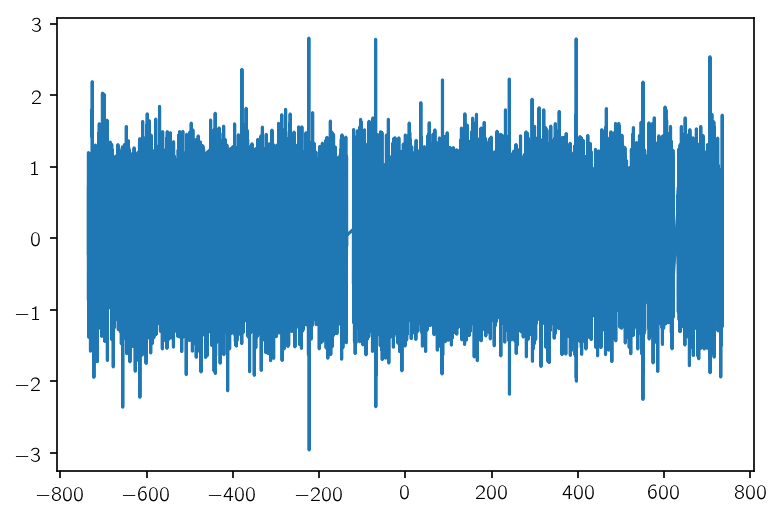

In [4]:
plt.plot(times,dmmags)

In [5]:
nu_arr = metadata[::6]
# m = np.ones_like(nu_arr, dtype=bool)
# m[[0, 3, 4, 5]] = False
# nu_arr = nu_arr[m]
# nu_arr = nu_arr[[0] + list(range(3, len(nu_arr)))]
nu_arr

array([ 20.5080714 ,  10.91478125,  12.0305683 ,  20.24167338,
        19.23387857,  22.49221118,  11.10705136,  10.24806042,  11.47952238])

In [6]:
orbits = pd.read_csv("orbits.csv").rename(columns = lambda x: x.strip())
orbits.columns

Index(['Name', 'Porb', 'Porb_sig_p', 'Porb_sig_m', 'a1sini/c',
       'a1sini/c_sig_p', 'a1sini/c_sig_m', 'e', 'e_sig_p', 'e_sig_m', 'phip',
       'phip_sig_p', 'phip_sig_m', 'varpi', 'varpi_sig_p', 'varpi_sig_m',
       'f(M)Msun', 'f(M)Msun_sig_p', 'f(M)Msun_sig_m', 'gradient',
       'grad_sig_p', 'grad_sig_m', 't_p', 't_p_sig_p', 't_p_sig_m', 'K1_ms',
       'K1_ms_sig_p', 'K1_ms_sig_m', 'median_segment_size'],
      dtype='object')

In [7]:
orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0
e_param = np.log(e) - np.log(1.0 - e)

In [8]:
a1d

0.0017877278472222223

Here's where the TensorFlow stuff starts. The "session" is the thing that will actually do that calculations.

In [9]:
sess = tf.InteractiveSession()

The way that TensorFlow works is that you define the operations on `Variable` and `placeholder` objects. Here we describe the model: 

In [10]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification

ad_tensor = tf.Variable(a1d + np.zeros_like(nu_arr), dtype=T)

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

In [11]:
# Here we define how the time delay will be calculated:
tau_tensor = -(1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

Here's how you could evaluate different parts of the model:

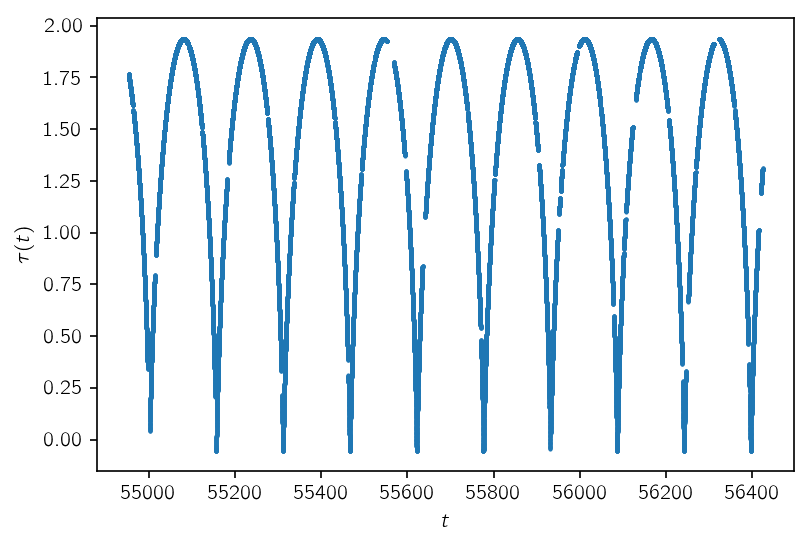

In [12]:
# We need to initialize the variables:
tf.global_variables_initializer().run()

# We'll also need to pass in the data:
data = {times_tensor: times, dmmags_tensor: dmmags}

# Let's plot the initial time delay
initial_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

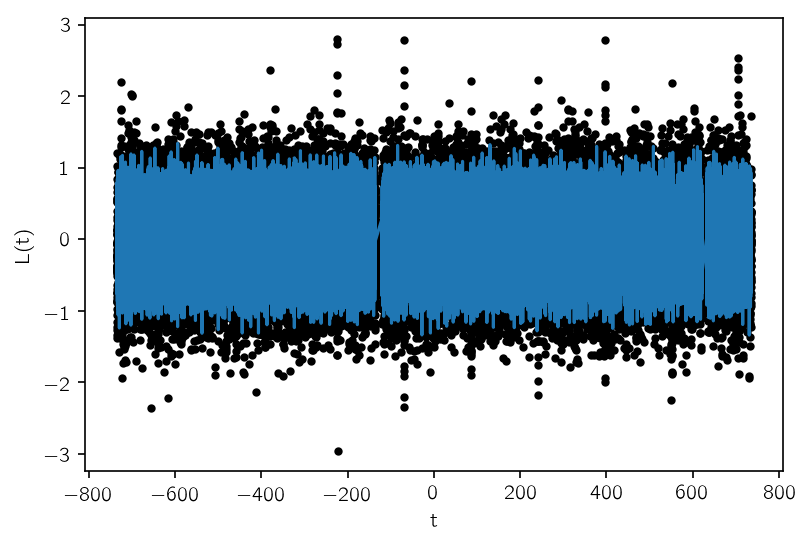

In [13]:
initial_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
# plt.xlim(100, 102)
# plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");

Now we'll fit the parameters. We'll iterate with different subsets a few times.

In [14]:
old_chi2 = sess.run(chi2_tensor, feed_dict=data)
for i in range(5):
    params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(ad_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [e_param_tensor, varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
        
    new_chi2 = sess.run(chi2_tensor, feed_dict=data)
    print(old_chi2 - new_chi2)
    if np.abs(old_chi2 - new_chi2) < 1.0:
        break
    old_chi2 = new_chi2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78276.614763
  Number of iterations: 26
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78342.678098
  Number of iterations: 17
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78342.678272
  Number of iterations: 1
  Number of functions evaluations: 4
85590.2045876
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78345.574562
  Number of iterations: 23
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function

Let's make the updated final plots.

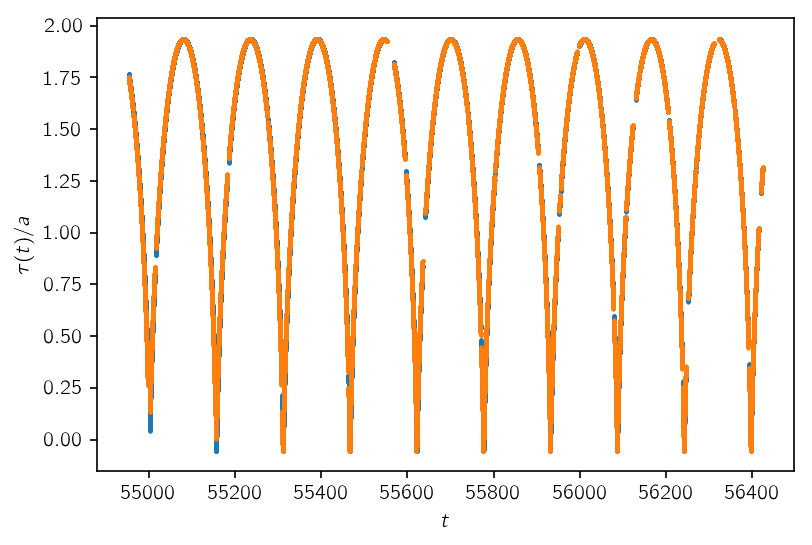

In [127]:
final_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.plot(times+tmid, final_tau, ".", ms=2)
plt.ylabel(r"$\tau(t) / a$")
plt.xlabel("$t$");

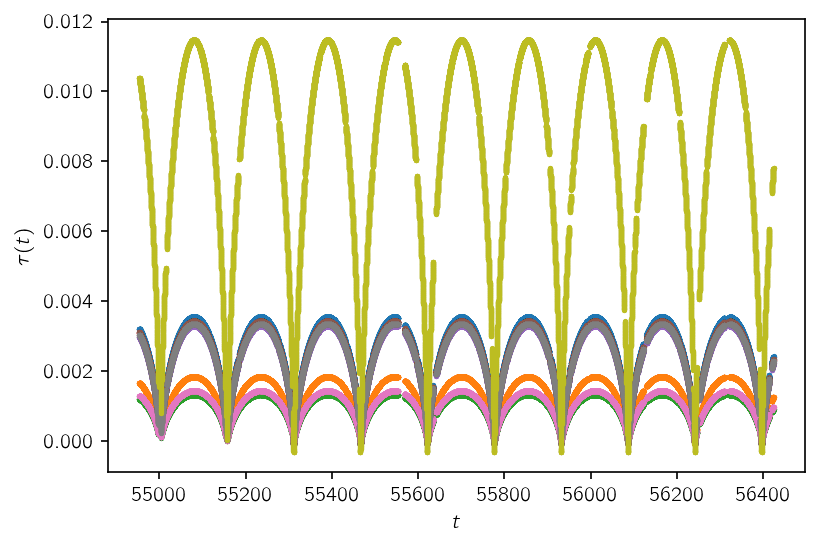

In [128]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times+tmid, sess.run(models, feed_dict=data), ".", ms=3)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

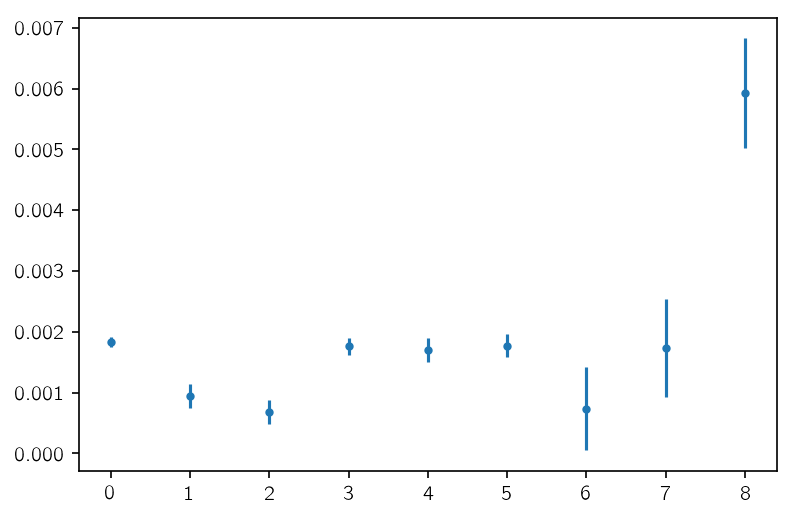

In [15]:
ivar = -np.diag(sess.run(tf.hessians(-0.5*chi2_tensor, ad_tensor), feed_dict=data)[0])
ad = sess.run(ad_tensor)
ad *= np.sign(ad[0])
sig = 1.0 / np.sqrt(ivar)
plt.errorbar(np.arange(len(ad)), ad, yerr=sig, fmt=".");

In [16]:
m = np.ones_like(ad, dtype=bool)
while True:
    var = 1.0 / np.sum(ivar[m])
    mu = np.sum(ivar[m] * ad[m]) * var
    var2 = np.sum(ivar[m] * (mu - ad[m])**2) * var
    m_new = np.abs(ad - mu) / np.sqrt(var) < 7.0
    if m.sum() == m_new.sum():
        m = m_new
        break
    m = m_new
ad = ad[m]
ivar = ivar[m]

In [17]:
m

array([ True, False, False,  True,  True,  True, False,  True, False], dtype=bool)

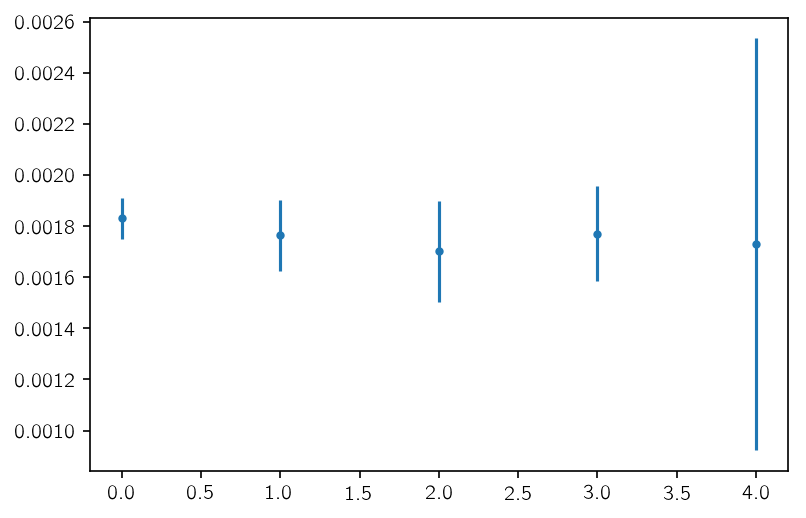

In [18]:
sig = 1.0 / np.sqrt(ivar)
plt.errorbar(np.arange(len(ad)), ad, yerr=sig, fmt=".");

In [19]:
if np.any(ad < 0):
    m1 = ad > 0
    m2 = ad <= 0
    ad = [
        np.sum(ivar[m1]*ad[m1]) / np.sum(ivar[m1]),
        np.sum(ivar[m2]*ad[m2]) / np.sum(ivar[m2]),
    ]
else:
    ad = [np.sum(ivar*ad) / np.sum(ivar)]

In [20]:
ad

[0.0017987913418049436]

In [21]:
inds = tf.cast(0.5 - 0.5 * (ad_tensor / tf.abs(ad_tensor)), tf.int32)
ad_params = tf.Variable(ad, dtype=T)
sess.run(ad_params.initializer)
ad_tensor = tf.gather(ad_params, inds)

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

In [22]:
old_chi2 = sess.run(chi2_tensor, feed_dict=data)
for i in range(5):
    params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(ad_params)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [e_param_tensor, varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(nu_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    new_chi2 = sess.run(chi2_tensor, feed_dict=data)
    print(old_chi2 - new_chi2)
    if np.abs(old_chi2 - new_chi2) < 1.0:
        break
    old_chi2 = new_chi2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78275.644133
  Number of iterations: 17
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78282.199599
  Number of iterations: 2
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78282.199931
  Number of iterations: 2
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -78282.966633
  Number of iterations: 10
  Number of functions evaluations: 15
11.292070354
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function va

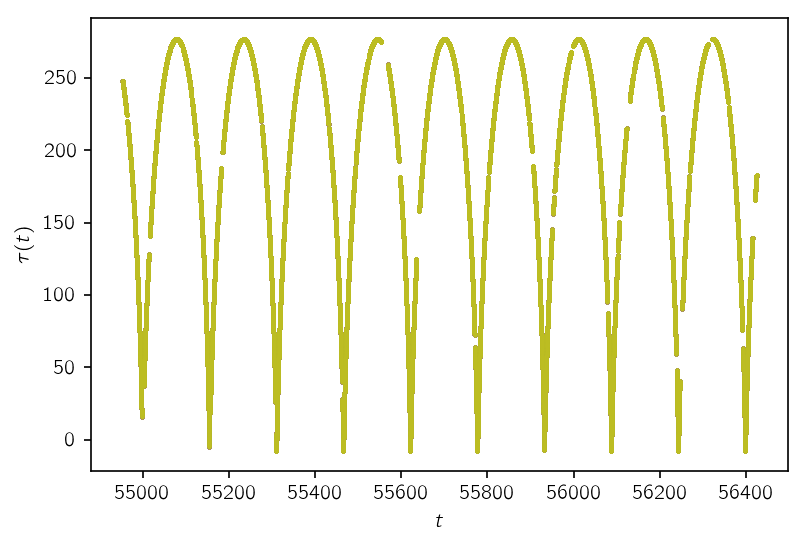

In [23]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times+tmid, 86400.0 * sess.run(models, feed_dict=data), ".", ms=2);
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

In [24]:
sess.run(e_tensor), e

(0.94724161782265703, 0.947241)

In [25]:
hess_tensor = tf.hessians(-0.5*chi2_tensor, params[:-1])

In [26]:
hess = sess.run(hess_tensor, feed_dict=data)

In [27]:
1. / np.sqrt(-hess[1])

0.078038682398607381

In [28]:
hess

[-32653.764274373076,
 -164.20264315781907,
 -4.2416591827592649,
 array([[ -3.17545780e+08]]),
 -2.4040432982902864,
 -180.71854782014529]

In [29]:
np.sqrt(-np.diag(np.linalg.inv(hess[3])))

array([  5.61173077e-05])

In [30]:
sess.run(ad_tensor)

array([ 0.00165639,  0.00165639,  0.00165639,  0.00165639,  0.00165639,
        0.00165639,  0.00165639,  0.00165639,  0.00165639])

In [31]:
a1d

0.0017877278472222223